# Table of Contents
## 0. [Imports, data loading and checking](#DL)
## 1. [Features properties](#FP)
## 2. [Features enginering](#FE)
## 3. [Model hipothesis and discussion](#MH)
## 4. [Model building](#MB)
## 5. [Model selection](#MS)
## 6. [Conclussions](#C)

In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
import re
from scipy.stats import kstest

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = [9,6]

# 0. Data loading and checking <a class="anchor" id="DL"></a>

In [13]:
train_data = pd.read_csv('train.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [14]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


We can see that Age, Embarked and Cabin contain null values, so, we will keep it in mind (in order to fill them) if we consider that some of these features is relevant after the properties overview.

# 1. Features properties <a class="anchor" id="FP"></a>

In this section we are going to study the features properties in order to two main aspects:

1. Marginal Distribution to know how a feature acts marginally 

2. Joint distribution with Survived to know which features are significantly related with the survivors

The methodology is basicly take an overview with a pie chart (in the case of cathegorical features) or an histogram (in the case of numerical values), then we will plot the joint distribution with a stacked bars diagram (in the case of cathegorical features) or an histogram hued by survivor (in the case of numerical features).

In [51]:
def build_pie_chart(serie):  #pd.Series
    
    plt.pie(serie.value_counts().values,
        labels=serie.value_counts().index, shadow=True, autopct='%.0f%%')
    plt.title('{} Pie Chart'.format(serie.name))
    plt.show()
    
def build_stacked_bars_chart(row_serie, col_serie=train_data['Survived']):
    
    pd.crosstab(row_serie,
                col_serie,
                normalize='index').plot(kind='bar', stacked=True)
    plt.show()

## 1.1 PassengerId

This feature seems to be a unique identifier for every passenger, but we do not need it because it matches with our dataframe indexes. It will be removed.

In [63]:
train_data.drop('PassengerId', axis=1, inplace=True)

## 1.2 Pclass

### MARGINAL DISTRIBUTION

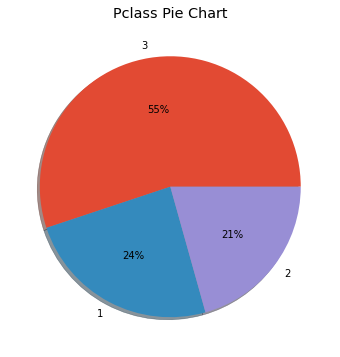

In [48]:
build_pie_chart(train_data['Pclass'])

### JOINT DISTRIBUTION WITH SURVIVED

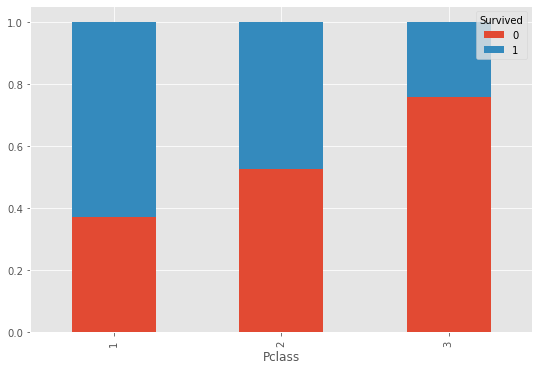

In [52]:
build_stacked_bars_chart(train_data['Pclass'])

From the above graphic we can see a relation between Survived and Pclass, as we can see, when Pclass decreases survivors proportion increases, so, it could be a feature in the model.

## 1.3 Sex

### MARGINAL DISTRIBUTION

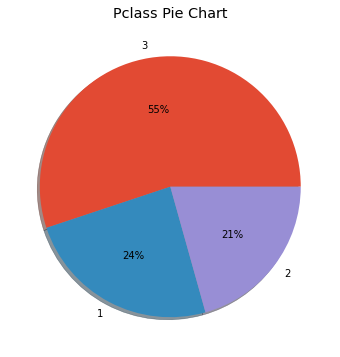

In [50]:
build_pie_chart(train_data['Pclass'])

### JOINT DISTRIBUTION WITH SURVIVED

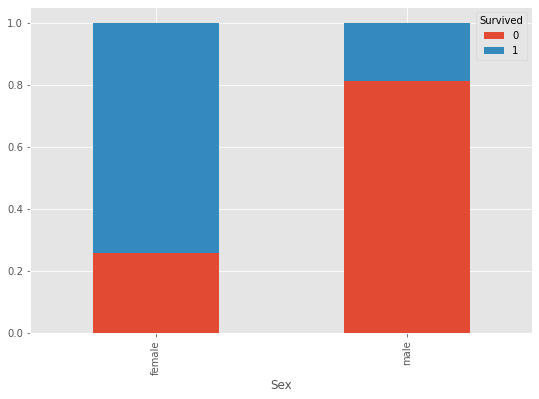

In [53]:
build_stacked_bars_chart(train_data['Sex'])

We can see that females represent aprroximately the thitd part of the passage, but, they have a significant higher probability to survive than males, so, it could be a feature in the model due to the strong relation.

## 1.4 Age

### MARGINAL DISTRIBUTION

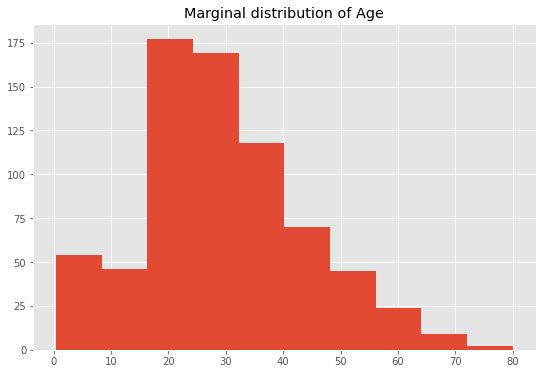

In [17]:
plt.hist(train_data['Age'])
plt.title('Marginal distribution of Age')
plt.show()

From the above histogram we can conclude that a great majority of the passage is between 18 and 30 years approximately. It seems a distribution skewed to the right it is not any well-known distribution. Specially, The normality assumption it is not justifed as we can see in the Kolmogorov-Smirnov pvalue.

In [23]:
kstest(train_data['Age'].dropna(), 'norm')

KstestResult(statistic=0.9650366565902186, pvalue=0.0)

### JOINT DISTRIBUTION WITH SURVIVED

<AxesSubplot:xlabel='Age', ylabel='Count'>

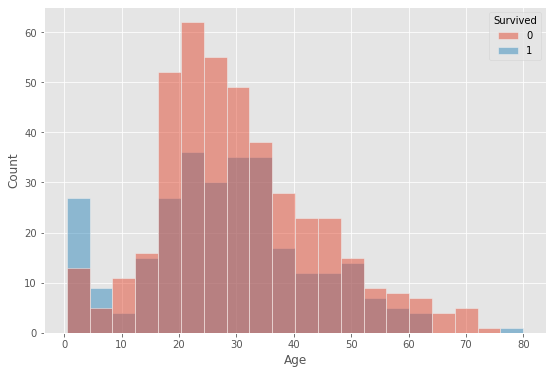

In [26]:
sns.histplot(data=train_data, x='Age', hue='Survived')

We can notice than childs have the highest chance to survive, and in the center of the distribution (young and middle-age persons) have approximately the same probability to survive or not. For the oldest people we can see that, in overall, nobody survived. 

That feature seems useful to predict survivors, we will include it in the model, but first, we have to implement a method to fill the null values, we will do it in later.

## 1.5 SibSp

### MARGINAL DISTRIBUTION

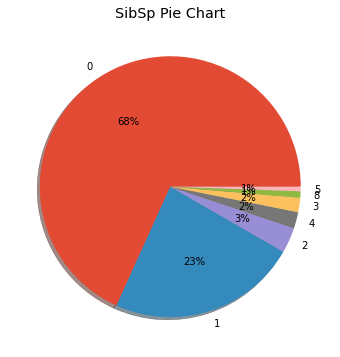

In [54]:
build_pie_chart(train_data['SibSp'])

### JOINT DISTRIBUTION WITH SURVIVED

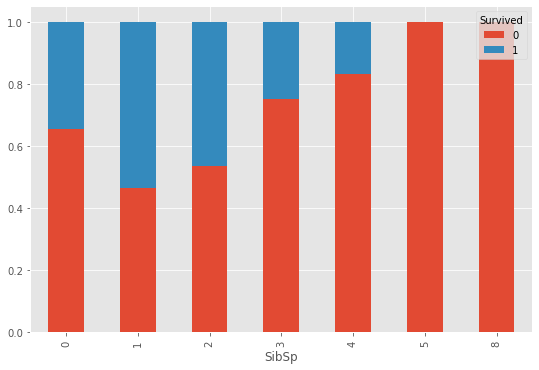

In [55]:
build_stacked_bars_chart(train_data['SibSp'])

We can see that the probability of survive decreases when siblings number increases (in overall), this feature could be included in the model.

## 1.6 Parch

### MARGINAL DISTRIBUTION

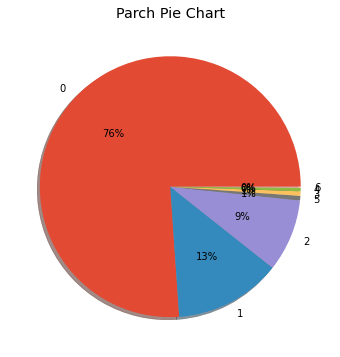

In [56]:
build_pie_chart(train_data['Parch'])

### JOINT DISTRIBUTION WITH SURVIVED

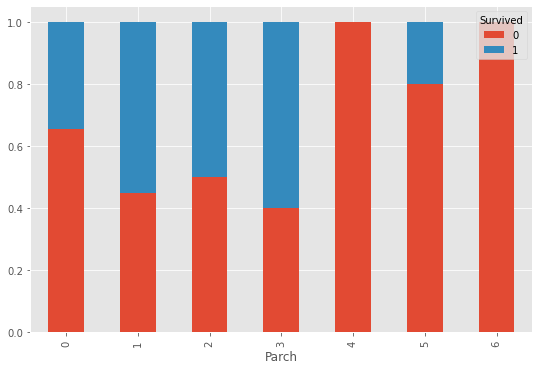

In [57]:
build_stacked_bars_chart(train_data['Parch'])

From the joint distribution we can see a (slight) relation between the Parch and Survived, where Parch increases the probability of survive decreases.

*Comment*: In overall, that feature has the same relation with survived as SibSp, so, it could be a good idea merge both features in a unique feature to prevent multicolineality in the model.

## 1.7 Fare

### MARGINAL DISTRIBUTION

<AxesSubplot:xlabel='Fare', ylabel='Count'>

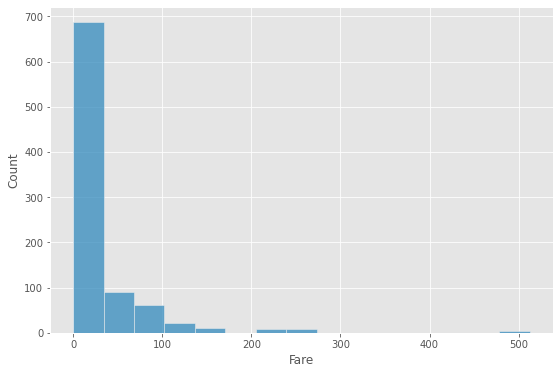

In [58]:
sns.histplot(data=train_data, x='Fare', bins=15)

### JOINT DISTRIBUTION WITH SURVIVED

<AxesSubplot:xlabel='Fare', ylabel='Count'>

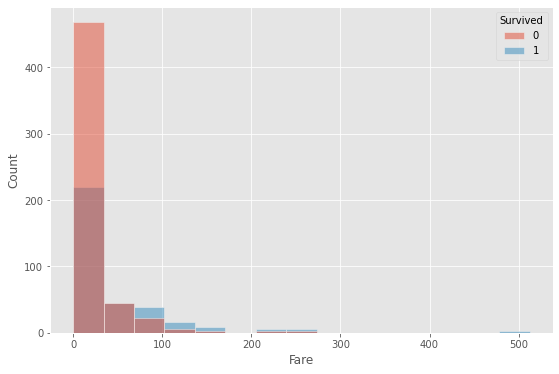

In [59]:
sns.histplot(data=train_data, x='Fare', hue='Survived', bins=15)

We can see that the probability of survive increases when Fare increases, so, it could be a feature in the model, but, probably, its correlated with Pclass, we have to take care if we include both features to prevent high correlations between model features.

## 1.8 Embarked

### MARGINAL DISTRIBUTION

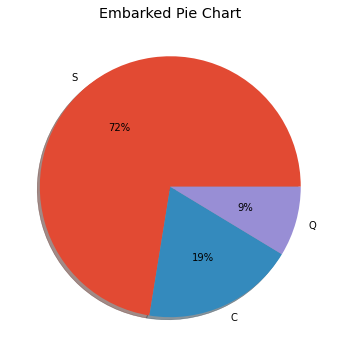

In [60]:
build_pie_chart(train_data['Embarked'])

### JOINT DISTRIBUTION WITH SURVIVED

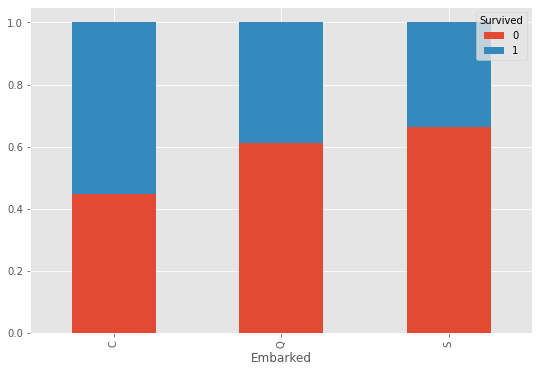

In [61]:
build_stacked_bars_chart(train_data['Embarked'])

We can see a slight relation between the place where passenger embarked and the probability of survive, but it does not seem significant. We will test different models including or not this feature and we will se if it is relevant or not.

## 1.9 Name

In [73]:
train_data.head(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In a simplistic approach, names do not seem a reason to survive a disaster, but, if we remind that we need to fill Age null values, definetly, the salutations before the surname can be very useful to locate persons in an age band. We will develop these ideas later.

## 1.10 Ticket and Cabin

That features seem to need a complex feature enginering and modifications, so, we will discuss them later if it is neccessary more complexity to the model.

# 2. Features enginering <a class="anchor" id="FE"></a>

# 3. Model hipothesis and discussion <a class="anchor" id="MH"></a>

# 4. Model building <a class="anchor" id="MB"></a>

# 5. Model selection <a class="anchor" id="MS"></a>

# 6. Conclussions <a class="anchor" id="C"></a>